In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd

# About
This notebook is the first step in playing with the activity dataset. The data is spread across a few datasets, and in this notebook I filter out uneeded data and merge the datasets into a single dataset.

# Dataset

Source: [Heterogeneity Activity Recognition Data Set](https://archive.ics.uci.edu/ml/datasets/Heterogeneity+Activity+Recognition)

The dataset and accompanying research can befound at UCIs dataset repository. The dataset is provided as a single archive. For my convenience I separated the included datasets into their own archives.

In [2]:
data_directory = os.environ["DATASET"] + "/heterogeneity_activity_recognition"
phone_accelerometer_path = f"{data_directory}/phones_accelerometer.zip"
phone_gyroscope_path = f"{data_directory}/phones_gyroscope.zip"
output_path = f"{data_directory}/processed/phones.zip"

In [3]:
pd.read_csv(phone_accelerometer_path).head(1)

,Index,Arrival_Time,Creation_Time,x,y,z,User,Model,Device,gt
0,0,1424696633908,1424696631913248572,-5.958191,0.688065,8.135345,a,nexus4,nexus4_1,stand


In [4]:
pd.read_csv(phone_gyroscope_path).head(1)

,Index,Arrival_Time,Creation_Time,x,y,z,User,Model,Device,gt
0,0,1424696633909,1424696631914042029,0.013748,-0.000626,-0.023376,a,nexus4,nexus4_1,stand


# Preprocessing

**`read`** opens a device dataset, and performs some basic processing. Columns are pruned and column names are normalized, categorial data is converted to categorical respresentations, and the dataset is indexed on time. The arrival time is used for the time index to provide a standard across all devices.

In [5]:
def read(path):
    return (
        pd.read_csv(path)
        .rename(columns=str.lower)
        .rename(columns={"gt": "target"})
        .set_index("arrival_time")
        .drop(columns=["creation_time", "device", "index", "model"])
        .assign(
            target=lambda df: pd.Categorical(df["target"]),
            user=lambda df: pd.Categorical(df["user"])
        )
    )

# Merge

**`df`** is the accelerometer and gyroscope datasets merged on their time axis. This produces rows with incomplete data where one dataset had a timestamp that the other did not. In those cases the data is dropped.

In [6]:
%time df = (read(phone_accelerometer_path).join(read(phone_gyroscope_path), lsuffix="_accel", rsuffix="_gyro").dropna()); df.head(1)

CPU times: user 46.2 s, sys: 4.82 s, total: 51 s
Wall time: 51.1 s


,x_accel,y_accel,z_accel,user_accel,target_accel,x_gyro,y_gyro,z_gyro,user_gyro,target_gyro
arrival_time,,,,,,,,,,
1424686733391,-2.779668,1.908179,8.927979,g,stand,0.015577,-0.043371,-0.014661,g,stand


## Merge Conflicts

Each dataset has a target and a user column that gets a unique suffix for each dataset. To make things easier to work with one of those columns is dropped, and the column names are returned to `target` and `user`.

In [7]:
def normalize_target(df):
    return (
        df.rename(columns={"target_accel": "target"})
        .drop(columns=["target_gyro"])
    )

In [8]:
def normalize_user(df):
    return (
        df.rename(columns={"user_accel": "user"})
        .drop(columns=["user_gyro"])
    )

# Balance

Number of occurrences by activity before balancing

In [9]:
df.target_accel.value_counts()

walk          2266727
sit           2062641
stand         1809463
stairsup      1762269
bike          1675293
stairsdown    1479768
Name: target_accel, dtype: int64

---
For this notebook I am using undersampling to balance the dataset.

In [10]:
def balance(strategy="undersample", seed=0):
    def F(df):
        count: int
        replace: bool
        target = pd.DataFrame()
        
        # oversample
        if "oversample" in strategy:
            count = df.target.value_counts().max()
            replace = True
        
        # undersample
        else:
            count = df.target.value_counts().min()
            replace = False
        
        for action in df.target.unique():
            sample = (
                df[df.target == action]
                .sample(n=count, replace=replace, random_state=seed)
            )
            
            target = pd.concat((target, sample), axis="rows")

        return target
    
    return F

# Apply Processing

In [11]:
%%time 
df = (
    df.pipe(normalize_target)
    .pipe(normalize_user)
    .pipe(balance(strategy="undersample"))
    .sort_index(axis="columns")
)

CPU times: user 1.87 s, sys: 483 ms, total: 2.35 s
Wall time: 2.36 s


# Visualize

In [12]:
f"total number of rows in the dataset {len(df)}"

'total number of rows in the dataset 8878608'

---
Random slice of the dataset

In [13]:
df.sample(n=10)

,target,user,x_accel,x_gyro,y_accel,y_gyro,z_accel,z_gyro
arrival_time,,,,,,,,
1424785025465,sit,b,8.605958,0.021686,0.232238,-0.007941,4.331111,0.026878
1424694804899,stairsup,c,6.895215,-0.309709,0.306454,-0.355218,7.048442,-0.282831
1424688396641,stairsup,g,-2.406677,-0.816116,0.006088,0.137750,10.213409,1.295951
1424782532380,walk,d,-4.305023,-0.346603,-0.366440,0.063568,14.374298,-0.266541
1424776819218,sit,i,5.209783,-0.011711,0.881066,-0.014883,8.264784,-0.006587
1424783263590,bike,d,-1.838724,-0.253509,-0.459681,-0.486860,9.959755,0.194866
1424779841333,walk,f,-1.542435,-0.090760,2.396423,0.080513,13.844467,0.017810
1424784945375,stand,b,-1.102234,0.011606,0.048935,0.016188,10.234833,0.111177
1424696838311,stand,a,-6.124649,0.019608,0.475464,-0.014114,7.645981,-0.037476


---
Number of occurrences by activity categry

In [14]:
df.target.value_counts()

walk          1479768
stand         1479768
stairsup      1479768
stairsdown    1479768
sit           1479768
bike          1479768
Name: target, dtype: int64

---
Sensor readings per user

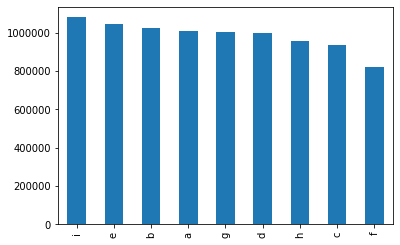

In [15]:
df.user.value_counts().plot(kind="bar");

---
Breakdown of the actions taken

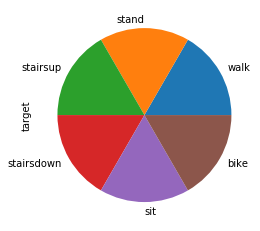

In [16]:
df.target.value_counts().plot(kind="pie");

## Activity By User

User:a


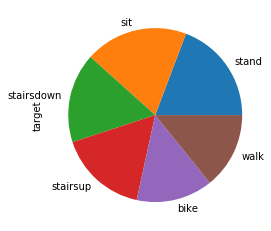

stand         194492
sit           193193
stairsdown    168575
stairsup      167133
bike          143679
walk          143562
Name: target, dtype: int64
User:b


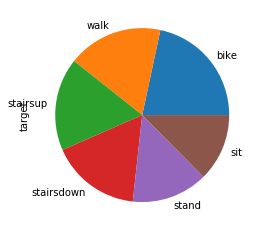

bike          222158
walk          181566
stairsup      177046
stairsdown    171363
stand         145404
sit           129021
Name: target, dtype: int64
User:c


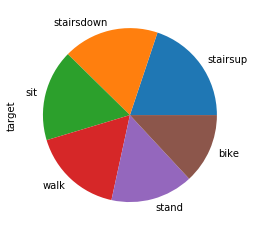

stairsup      186341
stairsdown    166808
sit           159486
walk          158801
stand         143787
bike          122650
Name: target, dtype: int64
User:d


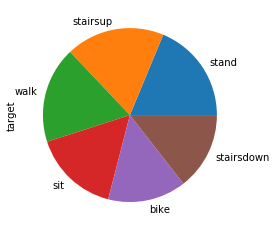

stand         187016
stairsup      183006
walk          178455
sit           159843
bike          145430
stairsdown    144248
Name: target, dtype: int64
User:e


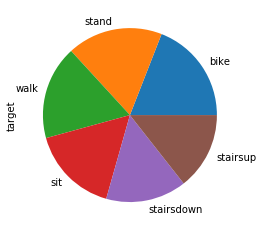

bike          199736
stand         185904
walk          182746
sit           171136
stairsdown    157136
stairsup      150755
Name: target, dtype: int64
User:f


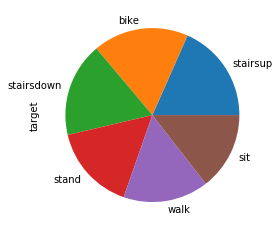

stairsup      150487
bike          145381
stairsdown    143710
stand         130706
walk          130164
sit           118492
Name: target, dtype: int64
User:g


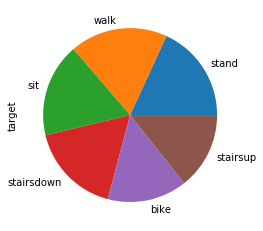

stand         181930
walk          181857
sit           174618
stairsdown    171716
bike          148604
stairsup      143474
Name: target, dtype: int64
User:h


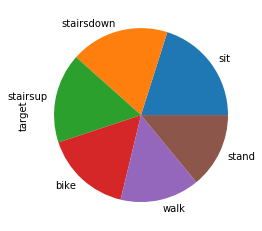

sit           192457
stairsdown    175016
stairsup      159681
bike          154440
walk          141092
stand         134168
Name: target, dtype: int64
User:i


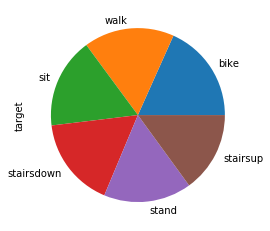

bike          197690
walk          181525
sit           181522
stairsdown    181196
stand         176361
stairsup      161845
Name: target, dtype: int64


In [17]:
for user in sorted(df.user.unique()):
    print(f"====================================\nUser:{user}")
    mask = df.user == user
    df[mask].target.value_counts().plot(kind="pie")
    plt.show()
    print(df[mask].target.value_counts())

# Export Dataset

In [18]:
%time df.to_csv(output_path)

CPU times: user 1min 47s, sys: 1.2 s, total: 1min 48s
Wall time: 1min 49s
